<a href="https://colab.research.google.com/github/vinhpeters/tf-exam/blob/main/10_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series forecasting

In [66]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

/bin/bash: /home/vinhp/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-05-10 14:51:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.4’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.1s    

2023-05-10 14:51:07 (1.78 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.4’ saved [178509/178509]



In [67]:
import pandas as pd

In [68]:
df = pd.read_csv('./BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [70]:
len(df)

2787

In [71]:
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


<Axes: xlabel='Date'>

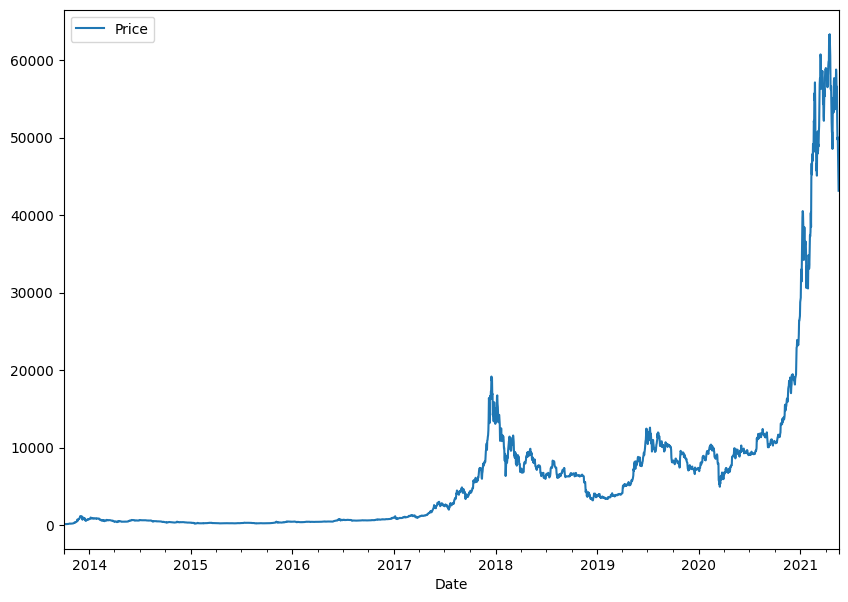

In [72]:
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10,7))

In [73]:
timesteps= bitcoin_prices.index.to_numpy()
prices= bitcoin_prices['Price'].to_numpy()

In [74]:
split_size = int(0.8*len(prices))

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

In [75]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

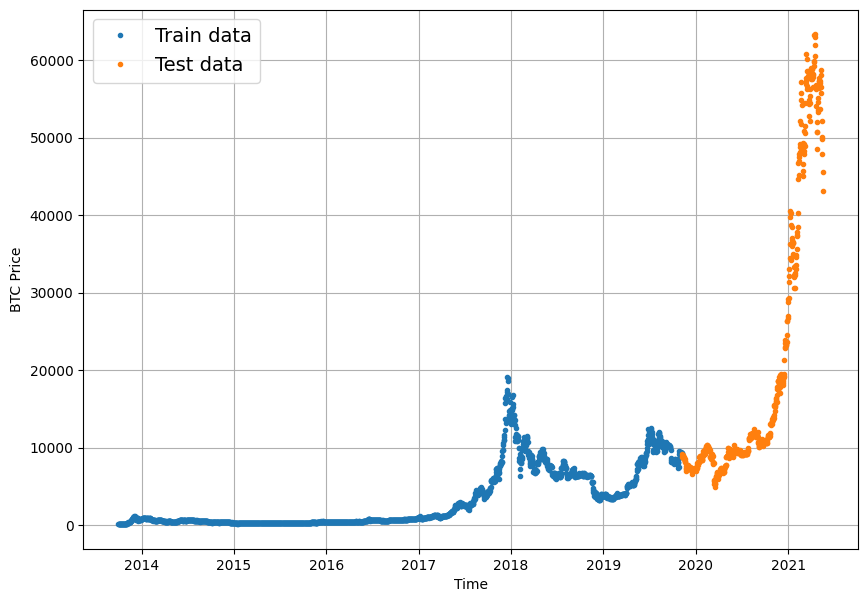

In [76]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Model 0 Baseline Naive Model

In [77]:
naive_forecast = y_test[:-1]
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

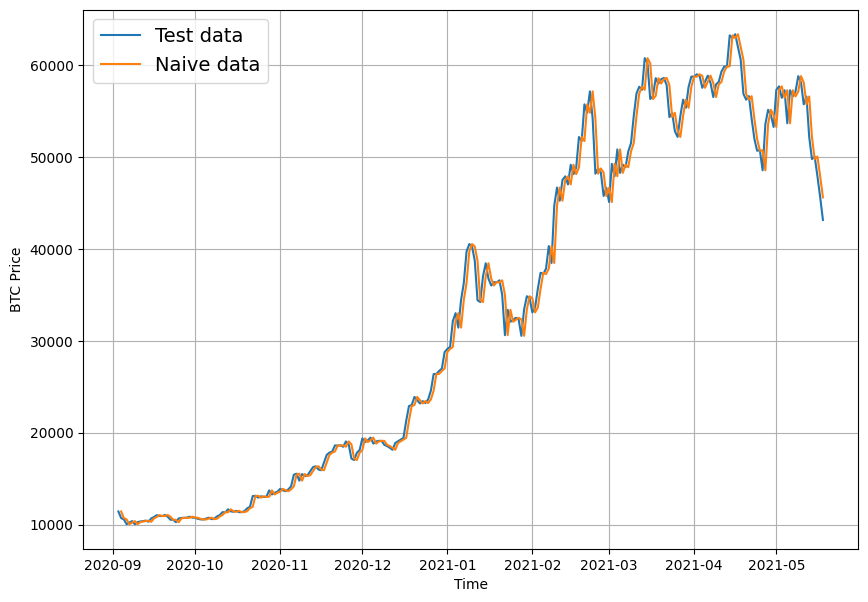

In [78]:
plt.figure(figsize=(10,7))
#plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, start=300, format='-' , label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=300, label='Naive data', format = '-')

## Evaluation metrics for timeseries forecasting

In [79]:
import tensorflow as tf
import numpy as np

In [80]:
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  mae_naive = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))

  return mae/mae_naive


In [81]:
mean_absolute_scaled_error(y_test[1:],y_pred=naive_forecast)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9995699939182624>

In [82]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [83]:
naive_results=evaluate_preds(y_test[1:], naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

## Windowing

In [84]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 

In [85]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):

  return x[:, :-horizon], x[:, -horizon:]

In [86]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [87]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows 
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [88]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [89]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [90]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [91]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

## Model Checkpoint

In [92]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1 Simple Dense Model

In [93]:
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_1_dense')

model_1.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae','mse'])

In [94]:
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100


2023-05-10 14:51:09.608216: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:274] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2023-05-10 14:51:09.608612: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:362 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-05-10 14:51:09.608668: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]]
2023-05-10 14:51:09.632843: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:274] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2023-05-10 14:51:09.633185: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:362 : INTERNAL: libdevice not f

InternalError: ignored

In [ ]:
model_1.evaluate(test_windows,test_labels)

In [ ]:
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense/')
model_1.evaluate(test_windows,test_labels)

In [ ]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

In [ ]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

In [ ]:
naive_results

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2 window = 30, horizon = 1 

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30 

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [ ]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_2_dense')

model_2.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae','mse'])

In [ ]:
model_2.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)]) # create ModelCheckpoint callback to save best model

In [ ]:
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense/')
model_2.evaluate(test_windows, test_labels)

In [ ]:
model_2_preds = make_preds(model_2, input_data=test_windows)

In [ ]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred = model_2_preds)
model_2_results

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_1_preds")

## Model 3 Window size = 30 horizon = 7

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30 

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [ ]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

model_3.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae','mse'])

In [ ]:
model_3.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)]) # create ModelCheckpoint callback to save best model

In [ ]:
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense/')
model_3.evaluate(test_windows, test_labels)

In [ ]:
model_3_preds = make_preds(model_3, input_data=test_windows)

In [ ]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred = model_3_preds)
model_3_results

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, format="-", label="model_3_preds")

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, format="-", label="model_3_preds")

In [ ]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

## Model 4 Conv1d

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [ ]:
train_windows[0].shape

In [ ]:
x = tf.constant(train_windows[0])
x

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [ ]:
print(expand_dims_layer(x))

In [ ]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
 layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)),
 layers.Conv1D(filters=128, kernel_size = 5, padding ='causal' ),
 layers.Dense(HORIZON)   
], name ='model_4_conv1D')

model_4.compile(loss = 'mae',
                optimizer= tf.keras.optimizers.Adam())

model_4.fit(train_windows,train_labels, batch_size=128, epochs =100, validation_data= (test_windows, test_labels), callbacks=[create_model_checkpoint(model_name=model_4.name)])



In [ ]:
model_4= tf.keras.models.load_model('/content/model_experiments/model_4_conv1D')

In [ ]:
model_4.evaluate(test_windows,test_labels)

In [ ]:
model_4_preds = make_preds(model_4, test_windows)

In [ ]:
model_4_results = evaluate_preds(tf.squeeze(test_labels), model_4_preds)

In [ ]:
model_4_results

## Model 5 RNN LSTM

In [ ]:
tf.random.set_seed(42)

inputs = layers.Input(shape=WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
#x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
#x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs=inputs, outputs=output, name='model_5_LSTM')
model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,train_labels, epochs = 100, batch_size=128,
            validation_data= (test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
model_5= tf.keras.models.load_model('/content/model_experiments/model_5_LSTM')

In [ ]:
model_5.evaluate(test_windows,test_labels)

In [ ]:
model_5_preds = make_preds(model_5, test_windows)

In [ ]:
model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)

In [ ]:
model_5_results

## Adding Bitcoin halving event features

In [ ]:
block_reward_1 = 50 # 3 Jan 2009
block_reward_2 = 25 # 8 Nov 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

In [ ]:
# Dates
block_reward_2_datetime = np.datetime64('2012-11-28')
block_reward_3_datetime = np.datetime64('2016-07-09')
block_reward_4_datetime = np.datetime64('2020-05-18')

In [ ]:
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

In [ ]:
block_reward_2_days, block_reward_3_days

In [ ]:
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

In [ ]:
bitcoin_prices_block.iloc[:block_reward_2_days,-1]= block_reward_2

In [ ]:
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1]= block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:,-1]= block_reward_4

In [ ]:
bitcoin_prices_block.tail()

## Test and train split for multivariate dataset

In [ ]:
bitcoin_prices_windowed = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f'Price+{i+1}'] = bitcoin_prices_windowed['Price'].shift(periods=i+1)
bitcoin_prices_windowed.head()

In [ ]:
X = bitcoin_prices_windowed.dropna().drop('Price',axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
split_size = int(len(X)*0.8)

X_train,y_train = X[:split_size], y[:split_size]
X_test,y_test = X[split_size:], y[split_size:]

In [ ]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_6_multivariate')

model_6.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae','mse'])

In [ ]:
model_6.fit(x=X_train, # train windows of 7 timesteps of Bitcoin prices
            y=y_train, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)]) # create ModelCheckpoint callback to save best model

In [ ]:
model_6= tf.keras.models.load_model('/content/model_experiments/model_6_multivariate')

In [ ]:
model_6.evaluate(test_windows,test_labels)

In [ ]:
model_6_preds = make_preds(model_6, test_windows)

In [ ]:
model_6_results = evaluate_preds(tf.squeeze(test_labels), model_6_preds)

In [ ]:
model_6_results

## Model 7 N-BEATS

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon= horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')
    
  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x= layer(x)
    theta = self.theta_layer(x)
    backcast,forecast = theta[:, :self.input_size], theta[:,-self.horizon]
    return backcast, forecast

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices.head()

In [ ]:
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f'Prices+{i+1}'] = bitcoin_prices_nbeats['Price'].shift(periods=i+1)
bitcoin_prices_nbeats.head()

In [ ]:
X = bitcoin_prices_nbeats.dropna().drop('Price',axis=1).astype(np.float32)
y = bitcoin_prices_nbeats.dropna()['Price'].astype(np.float32)
split_size = int(len(X)*0.8)

X_train,y_train = X[:split_size], y[:split_size]
X_test,y_test = X[split_size:], y[split_size:]

In [ ]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4 

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = WINDOW_SIZE + HORIZON
N_STACKS = 30


In [ ]:

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 horizon=HORIZON,
                                 n_neurons = N_NEURONS,
                                 n_layers = N_LAYERS,
                                 theta_size=THETA_SIZE,
                                 name='InitialBlock')

stack_input = layers.Input(shape = (INPUT_SIZE), name='stack_input')

residuals, forecast = nbeats_block_layer(stack_input)

for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                 horizon=HORIZON,
                                 n_neurons = N_NEURONS,
                                 n_layers = N_LAYERS,
                                 theta_size=THETA_SIZE,
                                 name=f'NBeatsBlock_{i}')(residuals)
  residuals = layers.subtract([residuals, backcast], name =f'subtract_{i}')
  forecast = layers.add([forecast, block_forecast], name = f'add_{i}')

model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name='model_7_NBEATS')

model_7.compile(loss='mae', optimizer = tf.keras.optimizers.Adam())

model_7.fit(train_dataset, epochs = N_EPOCHS, validation_data = test_dataset, verbose = 0, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                                                                                        patience=200,
                                                                                                                                        restore_best_weights=True),
                                                                                                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                                                                                             patience=100,
                                                                                                                                             verbose=1)])



In [ ]:
model_7.evaluate(test_dataset)

In [ ]:
model_7_preds = make_preds(model_7, test_dataset)


In [ ]:
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [ ]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [ ]:
%%time
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

In [ ]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

In [ ]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

In [ ]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

In [ ]:
bitcoin_prices_windowed.head()

## Model 9

In [ ]:
X_all = bitcoin_prices_windowed.dropna().drop(['Price'], axis=1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()['Price'].to_numpy()

In [ ]:
X_all[:5], y_all[:5]

In [ ]:
features_dataset_all = tf.data.Dataset.from_tensor_slices((X_all))
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

In [ ]:
tf.random.set_seed(42)

model_9 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
])

model_9.compile(loss=tf.keras.losses.mae, optimizer=tf.keras.optimizers.Adam())

model_9.fit(dataset_all, epochs = 100)

## Making future predictions

In [ ]:
INTO_FUTURE = 14

In [ ]:
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE, retrain = False) -> list:
  future_forecast = []
  last_window=values[-WINDOW_SIZE:]

  for _ in range(into_future):
    if retrain:
      model.fit(tf.expand_dims(last_window,axis=0), epochs = 100)
    future_pred = model.predict(tf.expand_dims(last_window,axis=0))
    print(f'Prediction on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n')

    future_forecast.append(tf.squeeze(future_pred).numpy()) 

    last_window= np.append(last_window, future_pred)[-WINDOW_SIZE:]

    return future_forecast

In [ ]:
future_forecast = make_future_forecasts(values=y_all, model = model_9, into_future = INTO_FUTURE, window_size=WINDOW_SIZE, retrain=False)

In [ ]:
def get_future_dates(start_date, into_future, offset =1):
  start_date = start_date + np.timedelta64(offset, 'D')
  end_date = start_date + np.timedelta64(into_future, 'D')

  return np.arange(start_date, end_date, dtype='datetime64')



In [ ]:
last_timestep = bitcoin_prices.index[-1]

In [ ]:
next_time_steps = get_future_dates(start_date=last_timestep, into_future = INTO_FUTURE )

In [ ]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format='-', label='Actural BTC Price')
plot_time_series(next_time_steps, future_forecast, format='-', label='Predicted BTC Price')

## Model 10

In [ ]:
btc_price_turkey= btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1]/100

In [ ]:
btc_price_turkey[-10]